# Adapted from the HLCA scArches mapping tutorial

This notebook is adapted from the scArches HLCA vignette 
[Mapping data to the Human Lung Cell Atlas for joint analysis and cell type label transfer](https://docs.scarches.org/en/latest/hlca_map_classify.html),
originally compiled by Lisa Sikkema and deposited in the [scArches](https://github.com/theislab/scarches/blob/master/notebooks/hlca_map_classify.ipynb) repository by Mohammad Lotfollahi and Theislab (BSD 3-Clause License).

We follow the overall structure, workflow, and selected parts of the documentation 
for clarity and reproducibility, while all datasets, analyses, and modifications presented here are original to the Human Skin Cell Atlas (HSCA).

**Full original BSD-3-Clause license text for adapted parts is included at the end of this notebook.**


# Mapping query datasets onto the HSCA Core with scArches

We project the query datasets onto the established HSCA core atlas using [scArches](https://www.nature.com/articles/s41587-021-01001-7). This integration enables joint analysis of the datasets and provides a basis for downstream analysis, including clustering and label transfer for initial cell type annotation.
We perform this analysis using scArches version 0.6.1.


### Import modules

In [112]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import scanpy as sc
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import scarches as sca
import gdown
from scarches.dataset.trvae.data_handling import remove_sparsity
from scipy import sparse
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

### File paths and directories setup:

In [113]:
path_input_core_emb = (
    "./scarches_output/HSCA/SCVI/models/query/surgery_output_embeddings/HSCA_core_scarches_emb.h5ad"
)
path_input_query_data = (
    "./query_dataset.h5ad"
)
dir_out_hsca_extended = "./scarches_output/HSCA/SCVI/query"
dir_reference_model = "./scarches_output/HSCA/SCVI/models/reference_model"  # directory where the reference model is stored
dir_surgery_models = "./scarches_output/HSCA/SCVI/models/query/surgery_models"  # directory where surgery model(s) will be stored
dir_surgery_embs = (
    "./scarches_output/HSCA/SCVI/models/query/surgery_output_embeddings"
)

### Create relevant directories

In [114]:
dirs = [
    dir_out_hsca_extended,
    dir_reference_model,
    dir_surgery_models,
    dir_surgery_embs,
]

for d in dirs:
    os.makedirs(d, exist_ok=True)
    print(f"Ensured directory exists: {d}")

Ensured directory exists: ./scarches_output/HSCA/SCVI/query
Ensured directory exists: ./scarches_output/HSCA/SCVI/models/reference_model
Ensured directory exists: ./scarches_output/HSCA/SCVI/models/query/surgery_models
Ensured directory exists: ./scarches_output/HSCA/SCVI/models/query/surgery_output_embeddings


## Import HSCA core embedding used as reference for mapping query datasets

In [115]:
reference_embedding = sc.read(path_input_core_emb)
reference_embedding

AnnData object with n_obs × n_vars = 293827 × 10
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'nCount_original.counts', 'nFeature_original.counts', 'seurat_clusters', 'orig_celltype_lvl_3', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'celltype_lvl_1', 'celltype_lvl_2', 'celltype_lvl_3', 'celltype_lvl_4', 'celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2', '_scvi_batch', '_scvi_labels', 'core_or_extension'
    obsm: 'X_scvi_emb', 'X_umap'

## Import query datasets to be mapped onto the HSCA core via transfer learning

In [116]:
adata_query_unprep = sc.read_h5ad(path_input_query_data)
adata_query_unprep

AnnData object with n_obs × n_vars = 24777 × 35326
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'genes', 'barcode'
    var: 'highly_variable', 'gene_names'
    layers: 'counts', 'norm'

In [117]:
# Get a list of all unique dataset names
adata_query_unprep.obs["Dataset"].unique()

['Sole-boldo_Lyko_2020']
Categories (1, object): ['Sole-boldo_Lyko_2020']

## Match feature naming from query data with reference model

Now we prepare our query data, so that it includes the right genes (this depends on the genes used for the reference model, missing genes are padded with zeros) and has those genes in the right order. Preparing your query data ensures data corectness and smooth running of the scArches reference mapping.

First, make sure that your counts matrix is sparse for memory efficiency:

In [118]:
adata_query_unprep.X = sparse.csr_matrix(adata_query_unprep.X)

Remove obsm and varm matrices to prevent errors downstream:

In [119]:
del adata_query_unprep.obsm
del adata_query_unprep.varm

Note that the data should have raw counts and not normalized counts in adata.X. Let’s do a quick check to see if we have integer data:

In [120]:
adata_query_unprep.X[:10, :30].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [121]:
adata_query_unprep.var.head(5)

highly_variable   gene_names
MIR1302-2HG            False  MIR1302-2HG
OR4F5                  False        OR4F5
AL627309.1             False   AL627309.1
AL627309.3             False   AL627309.3
AL627309.2             False   AL627309.2

The HSCA reference model was constructed from 13 uniformly processed datasets, all mapped to the same reference genome. This ensures a unique 1:1 mapping between gene symbols and gene IDs in the HSCA core and, consequently, in the reference model.

Since query datasets often contain only gene symbols, the reference model was trained on unambiguous gene symbols. This allows direct use of gene symbols from query datasets for mapping onto the reference model.

Alternatively, if a mapping based on gene IDs is preferred (e.g., when a different reference genome was used), gene symbols can be converted to gene IDs using BioMart. The overlap with the documented gene IDs of the reference model can then be computed, and the query dataset’s gene symbols adjusted accordingly, ensuring compatibility with the reference model.

In practice, the difference between using gene symbols or gene IDs is expected to be marginal, as highly variable genes (used for reference model training) tend to be strongly conserved across reference genomes at the gene symbol level.

Let’s download the HSCA-specific gene mapping:

In [122]:
path_gene_mapping_df = "./HSCA_hvgs_and_reference_model_genes.csv"

In [123]:
gene_name_to_gene_id_df = pd.read_csv(path_gene_mapping_df)
gene_name_to_gene_id_df.head(5)

gene_symbol          gene_id
0      SAMD11  ENSG00000187634
1       ISG15  ENSG00000187608
2     TNFRSF4  ENSG00000186827
3    C1QTNF12  ENSG00000184163
4     TNFRSF9  ENSG00000049249

Store your gene names in an adata.var.column if they are currently the index:

In [124]:
adata_query_unprep.var.head(2)

highly_variable   gene_names
MIR1302-2HG            False  MIR1302-2HG
OR4F5                  False        OR4F5

In [125]:
#adata_query_unprep.var["gene_names"] = adata_query_unprep.var.index

and then specify the gene name column name:

In [126]:
gene_name_column_name = "gene_names"

#### Map gene names to gene ids for all of the 2000 reference model genes that we can find in our data and subset it:

Check number of detected genes:

In [127]:
n_overlap = (
    adata_query_unprep.var[gene_name_column_name]
    .isin(gene_name_to_gene_id_df.gene_symbol)
    .sum()
)
n_genes_model = gene_name_to_gene_id_df.shape[0]
print(
    f"Number of model input genes detected: {n_overlap} out of {n_genes_model} ({round(n_overlap/n_genes_model*100)}%)"
)

Number of model input genes detected: 2000 out of 2000 (100%)


Subset query data to only the genes that are part of the modeling input, then map gene names to gene ids using the table above.

In [128]:
adata_query_unprep = adata_query_unprep[
    :,
    adata_query_unprep.var[gene_name_column_name].isin(
        gene_name_to_gene_id_df.gene_symbol
    ),
].copy()  # subset your data to genes used in the reference model
adata_query_unprep.var["gene_ids_model"] = adata_query_unprep.var[gene_name_column_name].map(
    dict(zip(gene_name_to_gene_id_df.gene_symbol, gene_name_to_gene_id_df.gene_id))
)  # add gene ids for the gene names, and store in .var

In [129]:
adata_query_unprep.var

highly_variable gene_names   gene_ids_model
SAMD11              False     SAMD11  ENSG00000187634
ISG15               False      ISG15  ENSG00000187608
TNFRSF4             False    TNFRSF4  ENSG00000186827
C1QTNF12            False   C1QTNF12  ENSG00000184163
TNFRSF9             False    TNFRSF9  ENSG00000049249
...                   ...        ...              ...
SLC6A14             False    SLC6A14  ENSG00000268104
GPC3                False       GPC3  ENSG00000147257
FGF13               False      FGF13  ENSG00000129682
BGN                 False        BGN  ENSG00000182492
CLIC2               False      CLIC2  ENSG00000155962

[2000 rows x 3 columns]

## Prepare query data for scArches:

Now that we have the right subset of features in our query anndata, we can finalize preparation of our query AnnData object for mapping. This includes padding of missing genes (setting them to 0).

In [130]:
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata=adata_query_unprep, reference_model=dir_reference_model, inplace=False
)

INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       
INFO     Found 100.0% reference vars in query data.                                                                


Your query adata will now have the same number of genes as the number of model input features:

You’ll see that scarches printed the percentage of model input features (“reference vars”) that it could find in the query data. If this number is too low, it will affect the quality of your mapping. For example, Sikkema et al. noticed for the HLCA,  low-quality mapping in a dataset for which they had only 1300 genes out of 2000 (65%).

## Perform surgery on reference model and train on query dataset without cell type labels

keep gene IDs in a separate column and set gene symbols as the index

In [131]:
condition_key = 'sample'
cell_type_key = 'inherited_celltype_lvl_3'

In [ ]:
sc.pl.umap(reference_embedding,color='inherited_celltype_lvl_3',size=1)

Get all unique source conditions; these samples will be mapped to the HSCA core via transfer learning


In [ ]:
source_conditions = reference_embedding.obs[condition_key].unique().tolist()
source_conditions

['HRS118996',
 'HRS118997',
 'HRS118998',
 'HRS118999',
 'HRS119000',
 'HRS119001',
 'HRS119002',
 'HRS119003',
 'HRS119004',
 'GSM4115878',
 'GSM4115880',
 'GSM4115885',
 'GSM4115886',
 'GSM4115868',
 'GSM4115870',
 'GSM4115872',
 'GSM4115874',
 'GSM4115875',
 'GSM4115876',
 'GSM3892577',
 'GSM3892578',
 'GSM3892579',
 'GSM3892580',
 'GSM8478430',
 'GSM8478429',
 'GSM5652699',
 'GSM5652700',
 'GSM5652701',
 'GSM5652702',
 'GSM5652703',
 'GSM5652704',
 'GSM5652705',
 'GSM5652706',
 'GSM5652707',
 'GSM5652708',
 'GSM5652709',
 'GSM5652710',
 'GSM5652711',
 'GSM5652712',
 'GSM4430462',
 'GSM4430464',
 'GSM4430466',
 'GSM4430467',
 'GSM4430468',
 'GSM4430470',
 'GSM4430471',
 'GSM4430475',
 'GSM3717037',
 'GSM3717038',
 'GSM4850587',
 'EGAF00002191947',
 'EGAF00002191954',
 'EGAF00002191956',
 'EGAF00002191945',
 'EGAF00002191949',
 'EGAF00002191953',
 'GSM5738236',
 'GSM5738237',
 'GSM5738238',
 'GSM8462811',
 'GSM8462812',
 'GSM8462813',
 'GSM8462814',
 'GSM8462815',
 'GSM8462816',
 'SA

Subset reference AnnData to the 2000 highly variable genes (matching the genes used in the query dataset)

In [ ]:
adata_query.obs[condition_key].unique().tolist()

['GSM3758115', 'GSM3758116', 'GSM3758117', 'GSM3758118', 'GSM3758119']

Identify genes present only in the reference or only in the target dataset (after HVG selection)

In [ ]:
diff_genes_1 = set(gene_name_to_gene_id_df.gene_symbol) - set(adata_query.var_names)  # Gene, die nur in adata1 sind
diff_genes_2 = set(adata_query.var_names) - set(gene_name_to_gene_id_df.gene_symbol)  # Gene, die nur in adata2 sind

print(f"Gene nur in adata1: {diff_genes_1}")
print(f"Gene nur in adata2: {diff_genes_2}")

Gene nur in adata1: set()
Gene nur in adata2: set()


In [ ]:
query_conditions = [
    sam for sam in adata_query.obs["sample"].unique().tolist()
    if sam not in reference_embedding.obs["sample"].unique()
]


In [ ]:
print(len(query_conditions))
print(len(adata_query.obs["sample"].unique().tolist()))

5
5


In [ ]:
query_conditions

['GSM3758115', 'GSM3758116', 'GSM3758117', 'GSM3758118', 'GSM3758119']

In [ ]:
surgery_epochs = 500

In [ ]:
for condition in query_conditions[::-1]: 
    print(condition)
    subadata_query = adata_query[adata_query.obs["sample"] == condition,:].copy()
    print(subadata_query.shape)
    # load model and set relevant variables:

    model = sca.models.SCVI.load_query_data(
    subadata_query,
    dir_reference_model,
    freeze_dropout = True,
    )
        # now train surgery model using reference model and query adata
    model.train(max_epochs=surgery_epochs, 
                plan_kwargs=dict(
                                 weight_decay=0.0,
                                 ),
                early_stopping = True,
                accelerator="cpu" 
                
               )
    
    surgery_path = os.path.join(dir_surgery_models, condition)
    if not os.path.exists(surgery_path):
        os.makedirs(surgery_path)
    model.save(surgery_path, overwrite=True)

GSM3758119
(5367, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 500/500: 100%|██████████| 500/500 [04:16<00:00,  1.94it/s, v_num=1, train_loss_step=384, train_loss_epoch=371]

INFO: `Trainer.fit` stopped: `max_epochs=500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [04:16<00:00,  1.95it/s, v_num=1, train_loss_step=384, train_loss_epoch=371]
GSM3758118
(5390, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 397/500:  79%|███████▉  | 397/500 [03:31<00:54,  1.88it/s, v_num=1, train_loss_step=355, train_loss_epoch=382]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 382.016. Signaling Trainer to stop.
GSM3758117
(5277, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 413/500:  83%|████████▎ | 413/500 [03:30<00:44,  1.96it/s, v_num=1, train_loss_step=489, train_loss_epoch=474]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 477.565. Signaling Trainer to stop.
GSM3758116
(2881, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 306/500:  61%|██████    | 306/500 [01:30<00:57,  3.38it/s, v_num=1, train_loss_step=441, train_loss_epoch=467]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 467.908. Signaling Trainer to stop.
GSM3758115
(5862, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 159/500:  32%|███▏      | 159/500 [01:29<03:12,  1.77it/s, v_num=1, train_loss_step=460, train_loss_epoch=427]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 427.784. Signaling Trainer to stop.


## Map query dataset samples onto the HSCA reference atlas

### Get latent representation of query dataset:

In [ ]:
for sample in query_conditions[::-1]: # from small to large datasets
    print(f"Working on {sample}...")
    subadata_query = adata_query[adata_query.obs["sample"] == sample,:].copy()
    surgery_path = os.path.join(dir_surgery_models, sample)
    model = sca.models.SCVI.load(surgery_path, subadata_query)
    subadata_query_latent = sc.AnnData(model.get_latent_representation(adata=subadata_query))
    subadata_query_latent.obs.index = subadata_query.obs.index
    subadata_query_latent.obs = subadata_query.obs.loc[subadata_query.obs.index, :]
    subadata_query_latent.write(os.path.join(dir_surgery_embs, f"{sample}_emb.h5ad"))

Working on GSM3758119...
INFO     File ./scarches_output/HSCA/SCVI/models/query/surgery_models/GSM3758119/model.pt already downloaded       


Working on GSM3758118...
INFO     File ./scarches_output/HSCA/SCVI/models/query/surgery_models/GSM3758118/model.pt already downloaded       
Working on GSM3758117...
INFO     File ./scarches_output/HSCA/SCVI/models/query/surgery_models/GSM3758117/model.pt already downloaded       
Working on GSM3758116...
INFO     File ./scarches_output/HSCA/SCVI/models/query/surgery_models/GSM3758116/model.pt already downloaded       
Working on GSM3758115...
INFO     File ./scarches_output/HSCA/SCVI/models/query/surgery_models/GSM3758115/model.pt already downloaded       


In [ ]:
query_embs = dict()

In [ ]:
for sample in query_conditions:
    query_embs[sample] =  sc.read_h5ad(os.path.join(dir_surgery_embs, f"{sample}_emb.h5ad"))

In [ ]:
query_embs

{'GSM3758115': AnnData object with n_obs × n_vars = 5862 × 10
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'genes', 'barcode', '_scvi_batch', '_scvi_labels',
 'GSM3758116': AnnData object with n_obs × n_vars = 2881 × 10
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'genes', 'bar

### Concatenate all individual target embeddings into a single AnnData object

In [ ]:
adata_query_latent_emb = sc.AnnData.concatenate(
    *query_embs.values(),
    join="outer",
    batch_key= "Batch", 
    batch_categories=list(query_embs.keys()),
    index_unique=None
)

In [ ]:
adata_query_latent_emb

AnnData object with n_obs × n_vars = 24777 × 10
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'genes', 'barcode', '_scvi_batch', '_scvi_labels', 'Batch'

In [ ]:
adata_query 

AnnData object with n_obs × n_vars = 24777 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'genes', 'barcode'
    var: 'highly_variable', 'gene_names'
    layers: 'counts', 'norm'

### Check that all cells in the concatenated latent embeddings are present in the original target AnnData


In [ ]:
adata_query.obs["core_or_query"] = "query"
reference_embedding.obs["core_or_query"] = "core"

In [ ]:
reference_embedding

AnnData object with n_obs × n_vars = 293827 × 10
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'nCount_original.counts', 'nFeature_original.counts', 'seurat_clusters', 'orig_celltype_lvl_3', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'celltype_lvl_1', 'celltype_lvl_2', 'celltype_lvl_3', 'celltype_lvl_4', 'celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2', '_scvi_batch', '_scvi_labels', 'core_or_extension', 'core_or_query'
    uns: 'inherited_celltype_lvl_3_colors'
    obsm: 'X_scvi_emb', 'X_umap'

In [ ]:
combined_emb = sc.concat(
    (reference_embedding, adata_query_latent_emb), index_unique=None, join="outer"
)  # index_unique="_", batch_key="ref_or_query")

combined_emb

AnnData object with n_obs × n_vars = 318604 × 10
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'nCount_original.counts', 'nFeature_original.counts', 'seurat_clusters', 'orig_celltype_lvl_3', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'celltype_lvl_1', 'celltype_lvl_2', 'celltype_lvl_3', 'celltype_lvl_4', 'celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2', '_scvi_batch', '_scvi_labels', 'core_or_extension', 'core_or_query', 'orig.ident', 'genes', 'Batch'
    obsm: 'X_scvi_emb', 'X_umap'

In [ ]:
import pandas as pd
for cat in combined_emb.obs.columns:
    if isinstance(combined_emb.obs[cat].values, pd.Categorical):
        pass
    elif pd.api.types.is_float_dtype(combined_emb.obs[cat]):
        pass
    else:
        print(
            f"Setting obs column {cat} (not categorical neither float) to strings to prevent writing error."
        )
        combined_emb.obs[cat] = combined_emb.obs[cat].astype(str)

Setting obs column barcode (not categorical neither float) to strings to prevent writing error.
Setting obs column _scvi_batch (not categorical neither float) to strings to prevent writing error.
Setting obs column _scvi_labels (not categorical neither float) to strings to prevent writing error.
Setting obs column core_or_query (not categorical neither float) to strings to prevent writing error.


In [ ]:
combined_emb.write_h5ad("combined_embedding.h5ad")

## Label Transfer from Reference to Query Datasets

**Note:** The following workflow and comments are directly adapted from the HLCA scArches tutorial 
([link](https://docs.scarches.org/en/latest/hlca_map_classify.html)). We include them here for clarity 
and to maintain the original explanations of each step.

All data and results shown in this notebook are specific to the Human Skin Cell Atlas (HSCA) and are original.

In [ ]:
#Next, we use a knn classifier to transfer the lables from the reference to the query. As 
#the HSCA includes 5 levels of annotations (from coarse to fine), we will do the label transfer for every level of annotation.
#Note that some cell types don’t have annotations for higher levels, e.g. mast cells do not have level 4 or 5 annotations. 
#For those cell types, we will “propagate” to the higher levels, i.e. you will see “Mast cell_3” in level 4 and 5 annotations. 
#(Most cell types don’t have a level 5 annotation!) Therefore, all highest level annotations can be found under level 5

In [ ]:
knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=reference_embedding,
    train_adata_emb="X",  # location of our joint embedding
    n_neighbors=50,
)

Weighted KNN with n_neighbors = 50 ... 

In [ ]:
reference_embedding.obs["inherited_celltype_lvl_5"].isnull().sum()

0

In [ ]:
labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata= adata_query_latent_emb,
    query_adata_emb="X",  # location of our embedding, query_adata.X in this case
    label_keys="inherited_celltype_lvl_",  # (start of) obs column name(s) for which to transfer labels
    knn_model=knn_transformer,
    ref_adata_obs=reference_embedding.obs,
)

finished!


In [ ]:
#With the commands above, we labeled every cell from the query (labels dataframe). Moreover, for each query cell we get
#an uncertainty score that tells you how confidently the label was assigned to the cell (uncert dataframe). 
#This uncertainty score is based on how consistent the reference labels were among the nearest neighbors of the query cell.
#High label transfer uncertainty can indicate a number of things:

#1. The cell lies in between two cellular phenotypes, e.g. in the case of a continuous transition of one cell type into another.

#2. The cell is of a cell type or subtype not present in the reference. For example, the HSCA core does not include erythrocytes. 
#Erythrocytes in a query dataset will therefore likely be labeled with high uncertainty. Similarly, disease samples might 
#include disease-affected cell types that look different from the cells in a healthy reference. 
#These also likely have high label transfer uncertainty.

#3. The mapping did not successfully remove batch-effects in the query data from the embedding. Query cells do not mix with the reference 
#in the joint embedding, complicating confident label transfer. To distinguish low-uncertainty from high-uncertainty transferred labels, 
#we will set our high-uncertainty labels to “unknown” instead of giving them a cell type label. Cells with high uncertainty should be 
#looked into in downstream analysis.

In [ ]:
#We set the uncertainty threshold to 0.2, limiting the false positive rate to <0.5 (as per Sikkema et al., bioRxiv 2022). 
#If you are dealing with data that you expect to look very different from your reference (e.g. mouse data or cell line data), 
#you could consider setting this threshold higher.

In [ ]:
uncertainty_threshold = 0.2

In [ ]:
uncert

inherited_celltype_lvl_1  \
barcode                                                            
GSE130973_SRR9036396_AAACCTGAGGCCGAAT-1                      0.0   
GSE130973_SRR9036396_AAACCTGAGTTAAGTG-1                      0.0   
GSE130973_SRR9036396_AAACCTGAGTTGTCGT-1                      0.0   
GSE130973_SRR9036396_AAACCTGCACAGGAGT-1                      0.0   
GSE130973_SRR9036396_AAACCTGCAGTCAGAG-1                 0.479976   
...                                                          ...   
GSE130973_SRR9036400_TTTGTCATCAACCAAC-1                      0.0   
GSE130973_SRR9036400_TTTGTCATCAGCCTAA-1                 0.020013   
GSE130973_SRR9036400_TTTGTCATCATCTGTT-1                      0.0   
GSE130973_SRR9036400_TTTGTCATCGGACAAG-1                      0.0   
GSE130973_SRR9036400_TTTGTCATCTTAACCT-1                      0.0   

                                        inherited_celltype_lvl_2  \
barcode                                                            
GSE130973_SRR9036396_AAACCTGAGGCCGAAT-1                      0.0   
GSE130973_SRR9036396_AAACCTGAGTTAAGTG-1                      0.0   
GSE130973_SRR9036396_AAACCTGAGTTGTCGT-1                      0.0   
GSE130973_SRR9036396_AAACCTGCACAGGAGT-1                      0.0   
GSE130973_SRR9036396_AAACCTGCAGTCAGAG-1                 0.479976   
...                                                          ...   
GSE130973_SRR9036400_TTTGTCATCAACCAAC-1                      0.0   
GSE130973_SRR9036400_TTTGTCATCAGCCTAA-1                 0.020013   
GSE130973_SRR9036400_TTTGTCATCATCTGTT-1                 0.020003   
GSE130973_SRR9036400_TTTGTCATCGGACAAG-1                      0.0   
GSE130973_SRR9036400_TTTGTCATCTTAACCT-1                      0.0   

                                        inherited_celltype_lvl_3  \
barcode                                                            
GSE130973_SRR9036396_AAACCTGAGGCCGAAT-1                 0.199999   
GSE130973_SRR9036396_AAACCTGAGTTAAGTG-1                 0.019999   
GSE130973_SRR9036396_AAACCTGAGTTGTCGT-1                 0.119994   
GSE130973_SRR9036396_AAACCTGCACAGGAGT-1                      0.0   
GSE130973_SRR9036396_AAACCTGCAGTCAGAG-1                 0.479976   
...                                                          ...   
GSE130973_SRR9036400_TTTGTCATCAACCAAC-1                  0.39999   
GSE130973_SRR9036400_TTTGTCATCAGCCTAA-1                 0.040008   
GSE130973_SRR9036400_TTTGTCATCATCTGTT-1                 0.020003   
GSE130973_SRR9036400_TTTGTCATCGGACAAG-1                      0.0   
GSE130973_SRR9036400_TTTGTCATCTTAACCT-1                  0.15999   

                                        inherited_celltype_lvl_4  \
barcode                                                            
GSE130973_SRR9036396_AAACCTGAGGCCGAAT-1                 0.740004   
GSE130973_SRR9036396_AAACCTGAGTTAAGTG-1                  0.55993   
GSE130973_SRR9036396_AAACCTGAGTTGTCGT-1                 0.119994   
GSE130973_SRR9036396_AAACCTGCACAGGAGT-1                 0.139997   
GSE130973_SRR9036396_AAACCTGCAGTCAGAG-1                 0.600032   
...                                                          ...   
GSE130973_SRR9036400_TTTGTCATCAACCAAC-1                  0.39999   
GSE130973_SRR9036400_TTTGTCATCAGCCTAA-1                 0.060022   
GSE130973_SRR9036400_TTTGTCATCATCTGTT-1                 0.020003   
GSE130973_SRR9036400_TTTGTCATCGGACAAG-1                 0.080031   
GSE130973_SRR9036400_TTTGTCATCTTAACCT-1                 0.539984   

                                        inherited_celltype_lvl_5  
barcode                                                           
GSE130973_SRR9036396_AAACCTGAGGCCGAAT-1                 0.740004  
GSE130973_SRR9036396_AAACCTGAGTTAAGTG-1                  0.55993  
GSE130973_SRR9036396_AAACCTGAGTTGTCGT-1                 0.119994  
GSE130973_SRR9036396_AAACCTGCACAGGAGT-1                 0.139997  
GSE130973_SRR9036396_AAACCTGCAGTCAGAG-1                  0.64003  
...                            

In [ ]:
labels.rename(
    columns={
        f"inherited_celltype_lvl_{lev}": f"inherited_celltype_lvl_{lev}_transferred_label_unfiltered"
        for lev in range(1, 6)
    },
    inplace=True,
)
uncert.rename(
    columns={
        f"inherited_celltype_lvl_{lev}": f"inherited_celltype_lvl_{lev}_transfer_uncert"
        for lev in range(1, 6)
    },
    inplace=True,
)

In [ ]:
adata_query_unprep.obs["Dataset"][0]

'Sole-boldo_Lyko_2020'

In [ ]:
labels.to_csv(f"./celltype_labels_{adata_query_unprep.obs['Dataset'][0]}.csv")
uncert.to_csv(f"./celltype_uncert_{adata_query_unprep.obs['Dataset'][0]}.csv")

In [ ]:
combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)

### Next, we create a filtered label column for each cell type, assigning labels with a transfer uncertainty greater than 0.2 as 'Unknown'.

In [ ]:
for lev in range(1, 6):
    combined_emb.obs[f"inherited_celltype_lvl_{lev}_transferred_label"] = combined_emb.obs[
        f"inherited_celltype_lvl_{lev}_transferred_label_unfiltered"
    ].mask(
        combined_emb.obs[f"inherited_celltype_lvl_{lev}_transfer_uncert"] > uncertainty_threshold,
        "Unknown",
    )

Let’s take a look at the percentage of cells set to “unknown” after our filtering:

In [ ]:
print(
    f"Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:"
)
for level in range(1, 6):
    print(
        f"Level {level}: {np.round(sum(combined_emb.obs[f'inherited_celltype_lvl_{level}_transferred_label'] =='Unknown')/adata_query.n_obs*100,2)}%"
    )

Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 1.12%
Level 2: 2.52%
Level 3: 16.98%
Level 4: 40.4%
Level 5: 43.04%


# Visualization of the joint reference and query embedding
We will use a UMAP plot of our data to visually inspect the results of the mapping and label transfer. Calculating this will take a while.

In [ ]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)

Let’s first take a look at where our query cells are located in the umap. If they are completely separate from the reference, this could be a sign that something went wrong in the mapping. In our case, the query cells are largely mixing with or close to the reference cells in the UMAP.

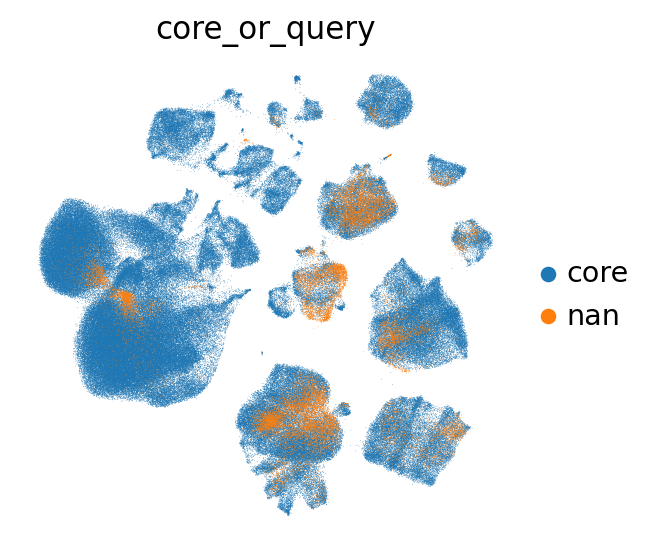

In [ ]:
sc.pl.umap(combined_emb, color="core_or_query", frameon=False, wspace=0.6)

Now let’s take a look at the transferred labels, at every level. Note that the color for “Unknown” switches per plot, and that all cells from the reference are set to NA.

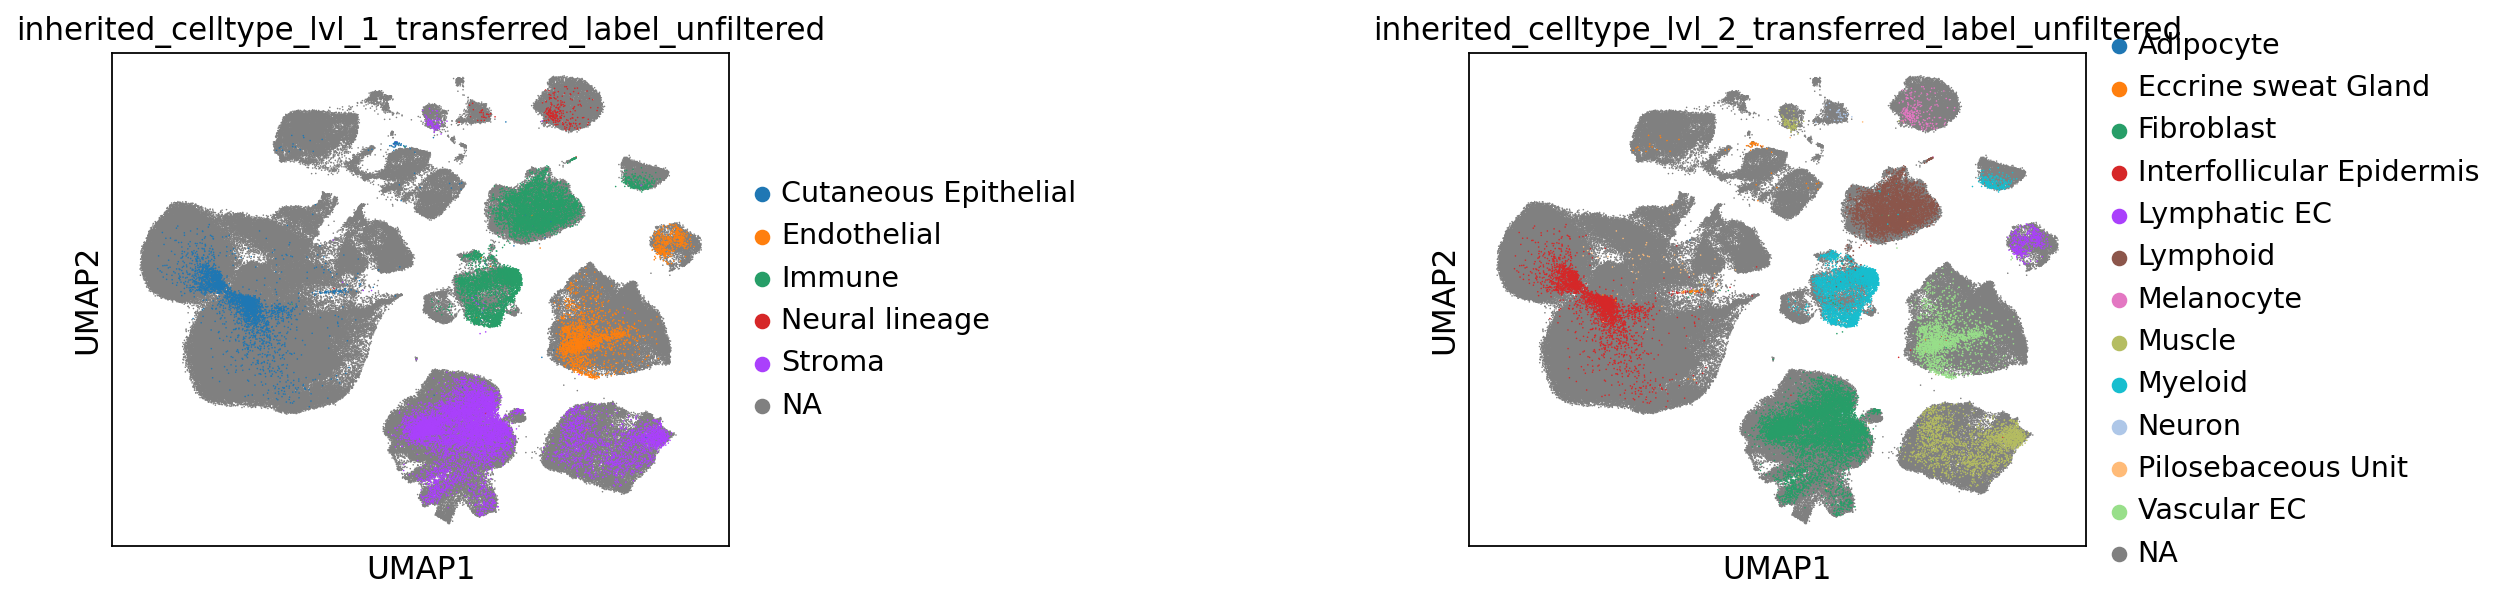

In [ ]:
sc.pl.umap(
    combined_emb,
    color=[f"inherited_celltype_lvl_{lev}_transferred_label_unfiltered" for lev in range(1, 3)],
    na_color="grey",
    ncols=2,
    size=2,
    wspace=1,
)

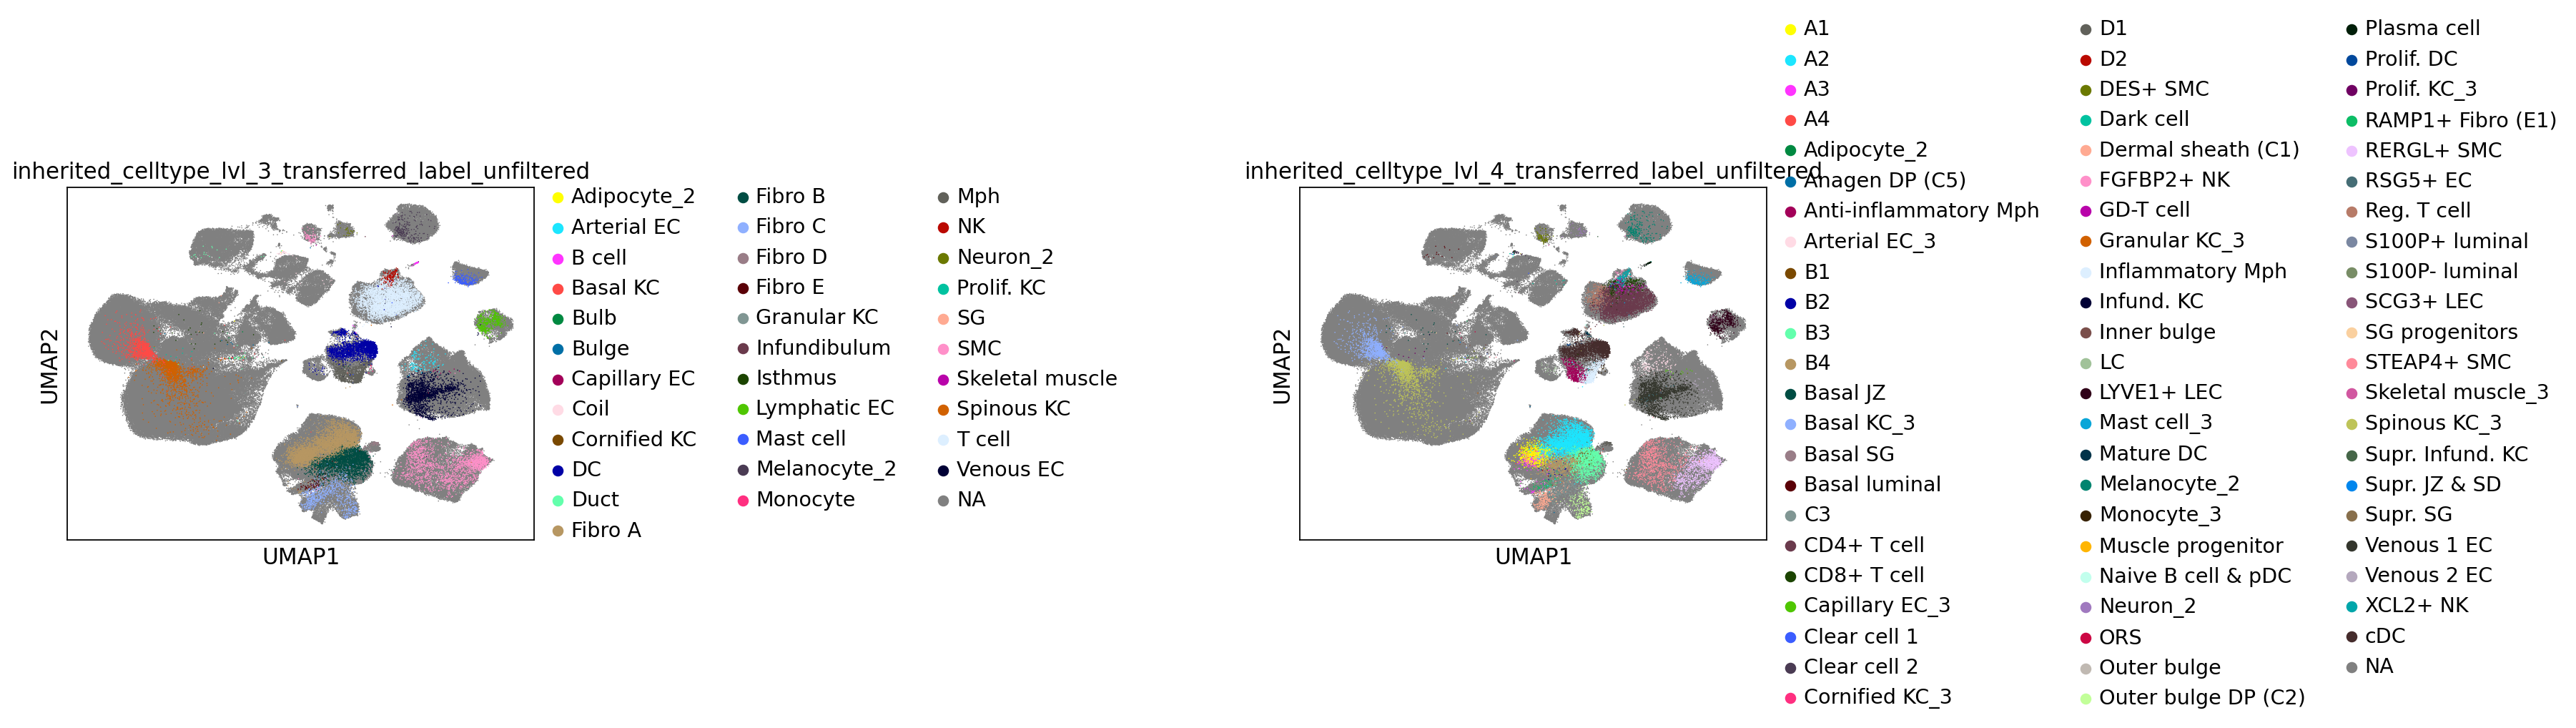

In [ ]:
sc.pl.umap(
    combined_emb,
    color=[f"inherited_celltype_lvl_{lev}_transferred_label_unfiltered" for lev in range(3, 5)],
    na_color="grey",
    ncols=2,
    size=2,
    wspace=1.4,
)

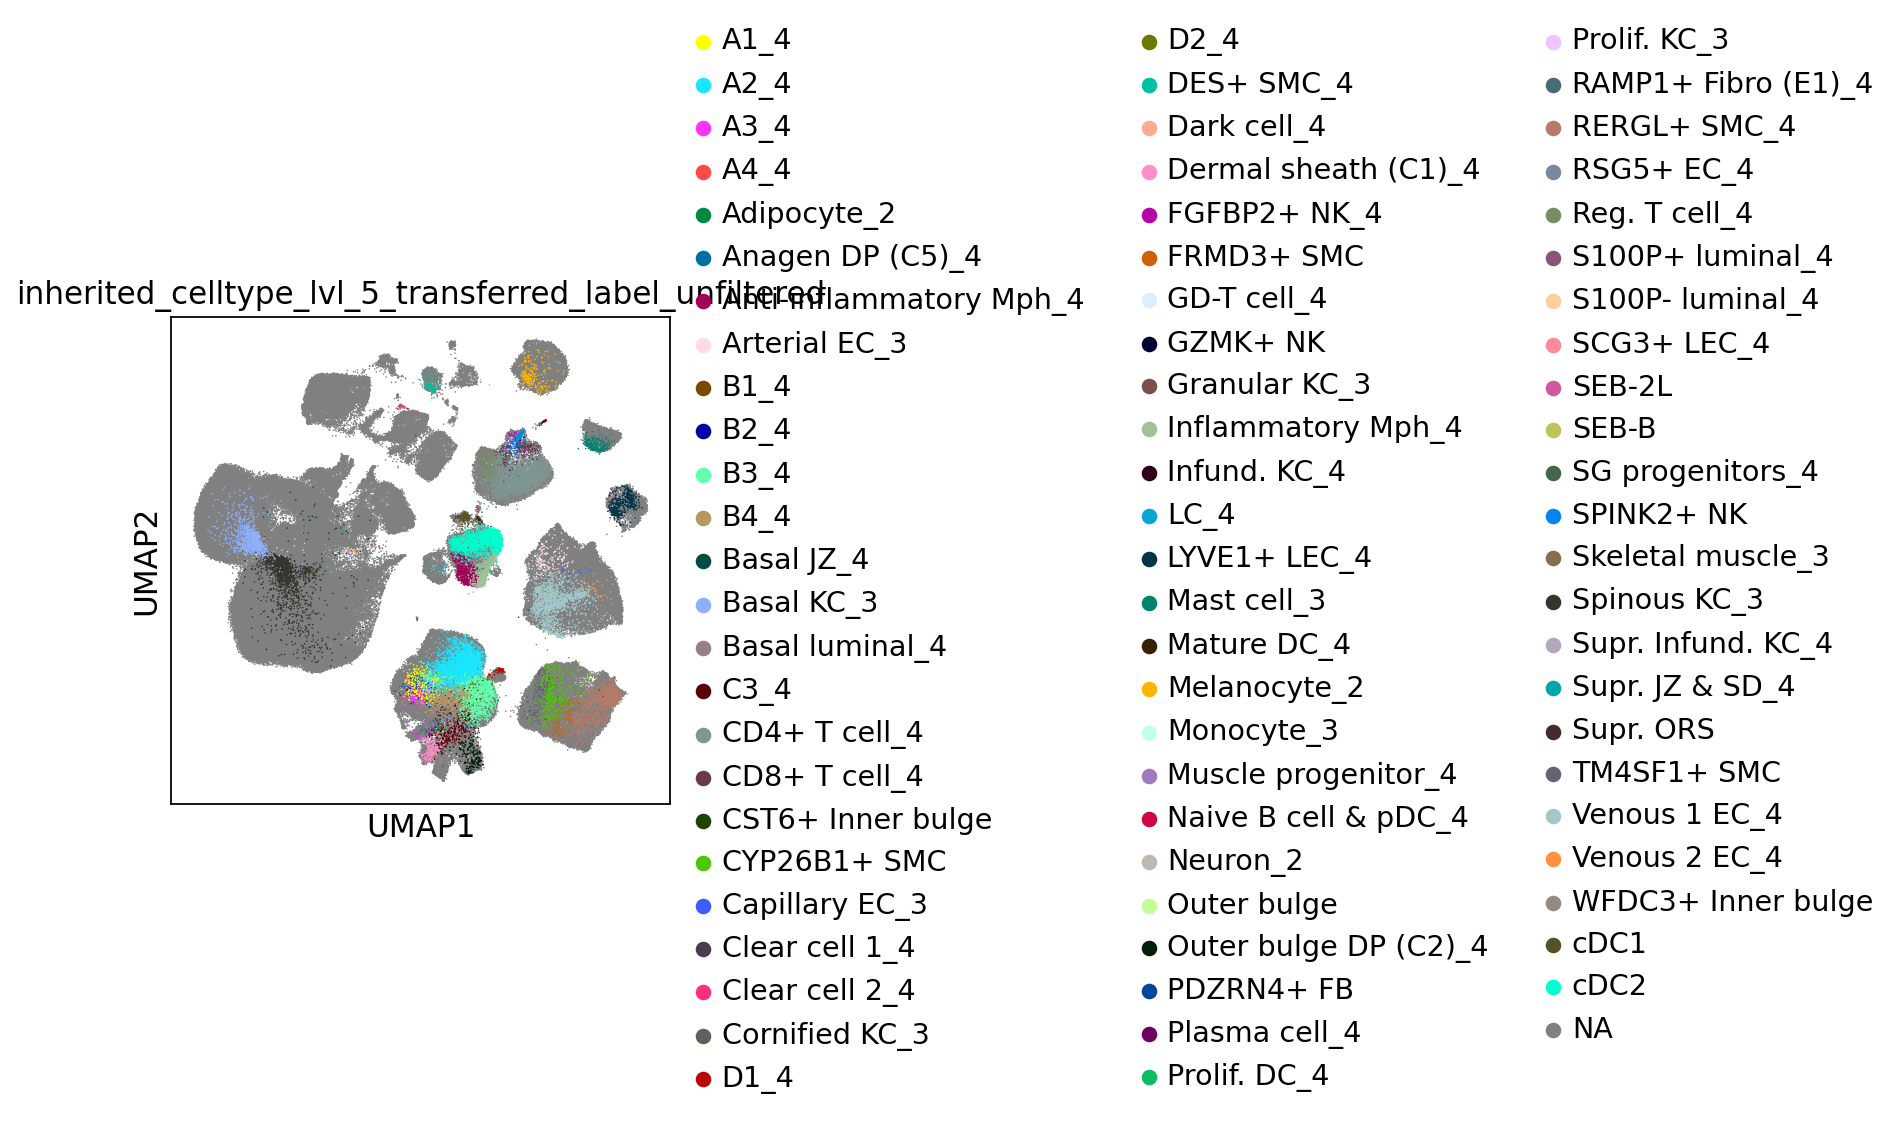

In [ ]:
sc.pl.umap(
    combined_emb,
    color=[f"inherited_celltype_lvl_5_transferred_label_unfiltered"],
    na_color="grey",
    size=2,
)

For your reference, these are the annotations of the reference atlas:

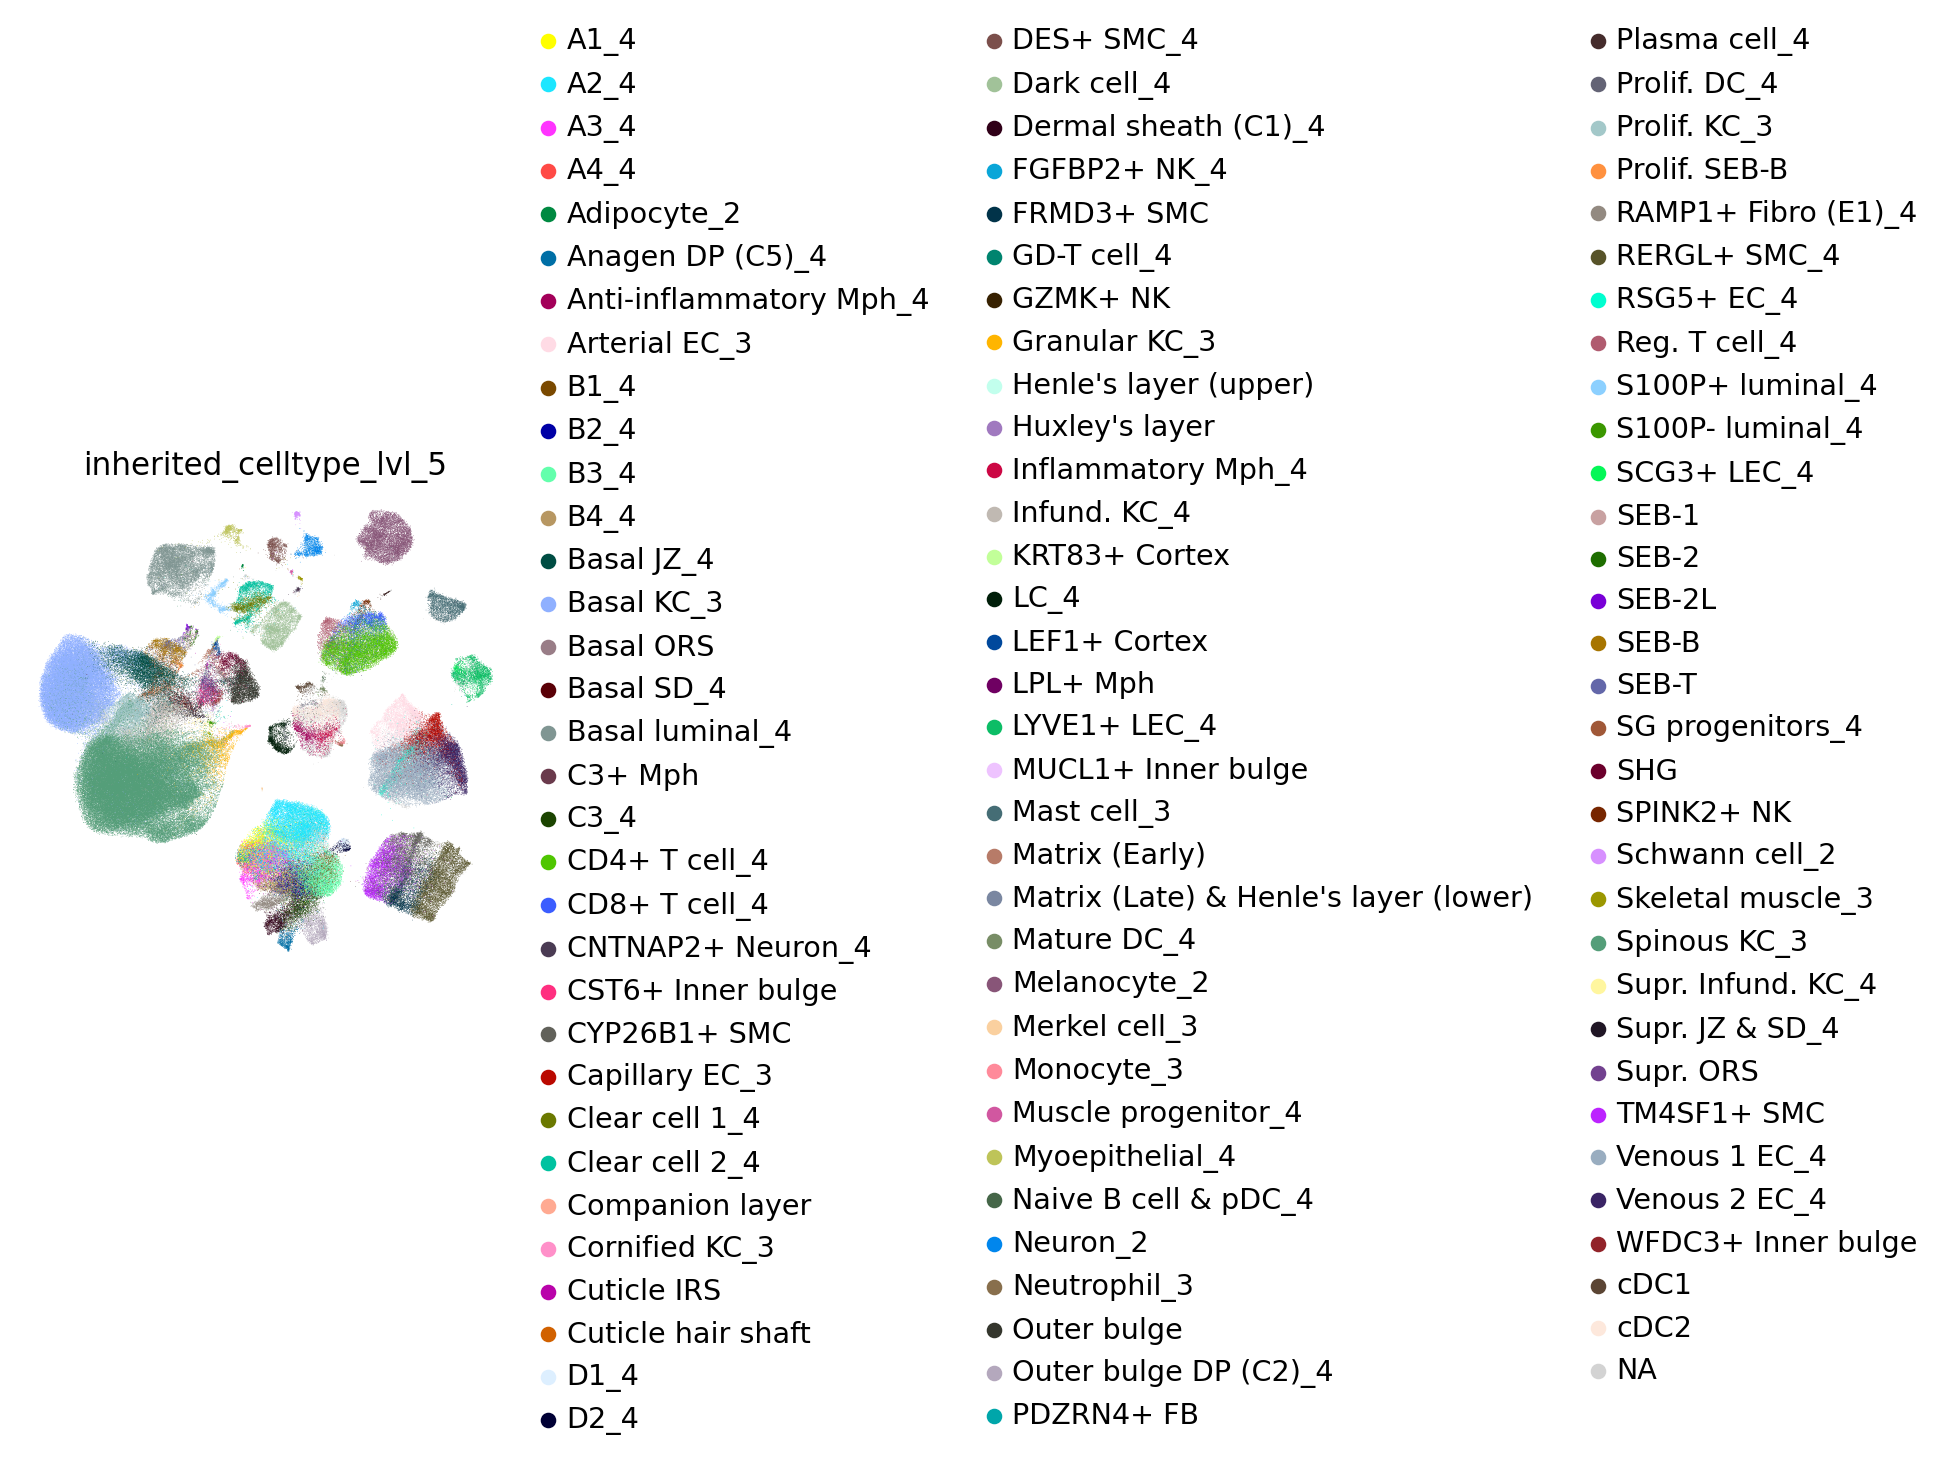

In [ ]:
sc.pl.umap(combined_emb, color="inherited_celltype_lvl_5", frameon=False, wspace=0.6)

# Visualization of the query alone, using reference-based embedding and including original gene expression values:

To get a better look at the query and the uncertainty levels, we can go back to the original query object (without reference, and with all genes still included), add the learned embedding and transfered labels, and calculate the UMAP:

In [ ]:
adata_query_final = (
    adata_query.copy()
)  # copy the original query adata, including gene counts

In [ ]:
adata_query_final.obsm["X_scarches_emb"] = adata_query_latent_emb[
    adata_query_final.obs.index, :
].X  # copy over scArches/reference-based embedding

If your original query_adata has gene ids instead of gene symbols as var.index, switch that here for easier gene querying. Adapt column names where necessary.

In [ ]:
adata_query_final.var

highly_variable gene_names
SAMD11              False     SAMD11
ISG15               False      ISG15
TNFRSF4             False    TNFRSF4
C1QTNF12            False   C1QTNF12
TNFRSF9             False    TNFRSF9
...                   ...        ...
SLC6A14             False    SLC6A14
GPC3                False       GPC3
FGF13               False      FGF13
BGN                 False        BGN
CLIC2               False      CLIC2

[2000 rows x 2 columns]

In [ ]:
adata_query_final.var.index

Index(['SAMD11', 'ISG15', 'TNFRSF4', 'C1QTNF12', 'TNFRSF9', 'AL034417.2',
       'CA6', 'CTNNBIP1', 'RBP7', 'ANGPTL7',
       ...
       'TMEM164', 'CHRDL1', 'PAK3', 'XACT', 'HTR2C', 'SLC6A14', 'GPC3',
       'FGF13', 'BGN', 'CLIC2'],
      dtype='object', length=2000)

In [ ]:
#adata_query_final.var["gene_ids"] = adata_query_final.var.index
#adata_query_final.var.index = adata_query_final.var.gene_names
#adata_query_final.var.index.name = None

In [ ]:
adata_query_final.X

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3020049 stored elements and shape (24777, 2000)>

In [ ]:
adata_query_final.X = adata_query_final.X.astype(float)

normalize gene counts and log transform (we’ll do a simple total counts normalization here for simplicity):

In [ ]:
sc.pp.normalize_per_cell(adata_query_final, counts_per_cell_after=10000)
sc.pp.log1p(adata_query_final)

copy over label transfer columns:

In [ ]:
for col in combined_emb.obs.columns:
    if col.startswith("inherited_celltype_lvl") and "transfer" in col:
        adata_query_final.obs[col] = combined_emb.obs.loc[
            adata_query_final.obs.index, col
        ]

calculate neigbhor graph based on scArches embedding, and generate UMAP:

In [ ]:
sc.pp.neighbors(adata_query_final, use_rep="X_scarches_emb")
sc.tl.umap(adata_query_final)

Visualize label transfer details for a level of choice:

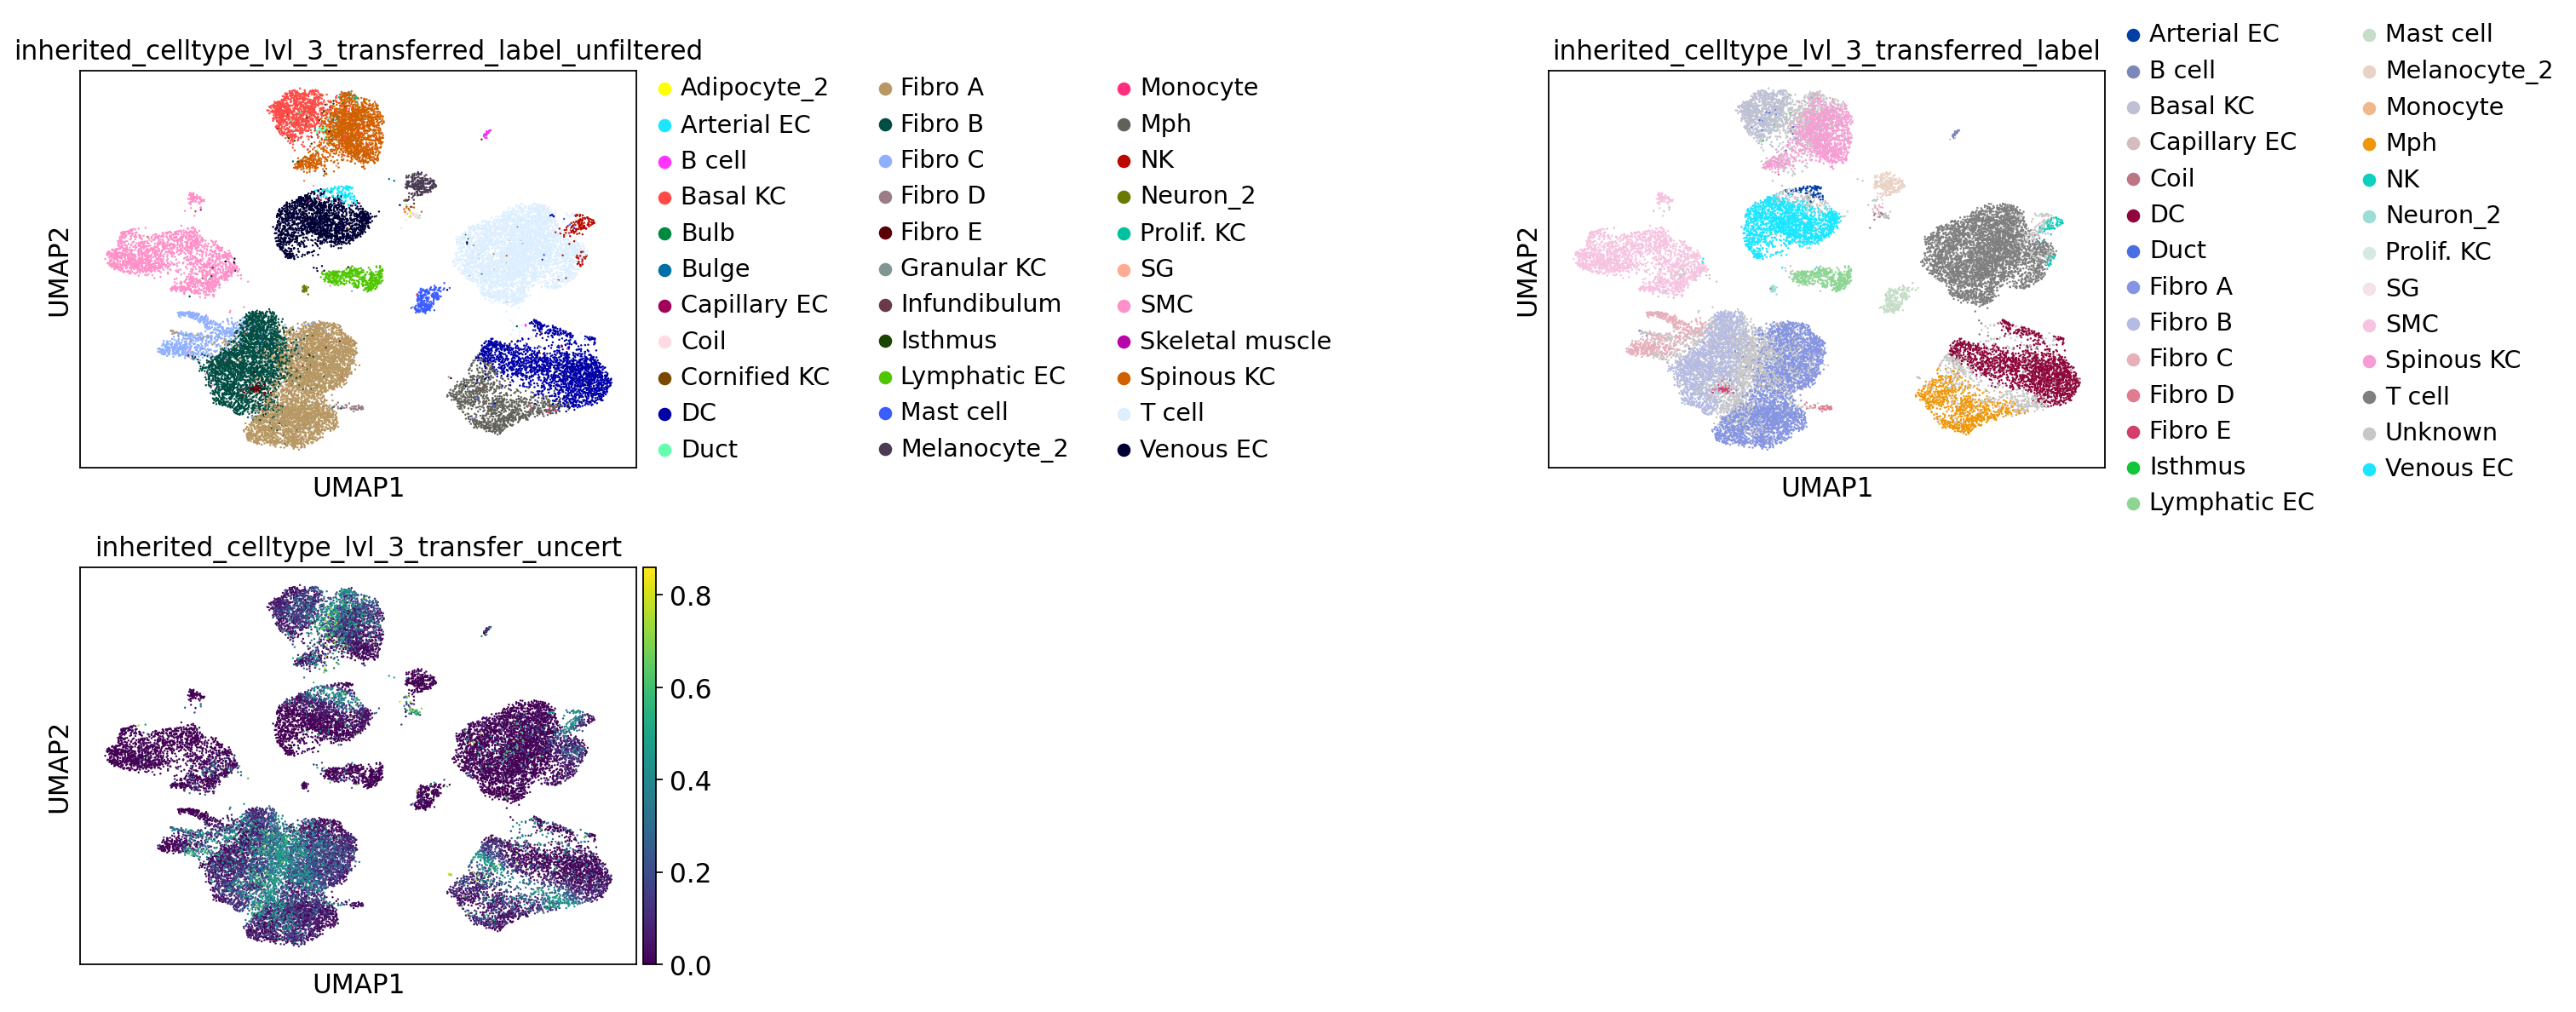

In [ ]:
lev = 3
sc.pl.umap(
    adata_query_final,
    color=[
        f"inherited_celltype_lvl_{lev}_transferred_label_unfiltered",
        f"inherited_celltype_lvl_{lev}_transferred_label",
        f"inherited_celltype_lvl_{lev}_transfer_uncert",
    ],
    wspace=1.4,
    ncols=2,
)

Now visualize gene expression of any genes of your interest:

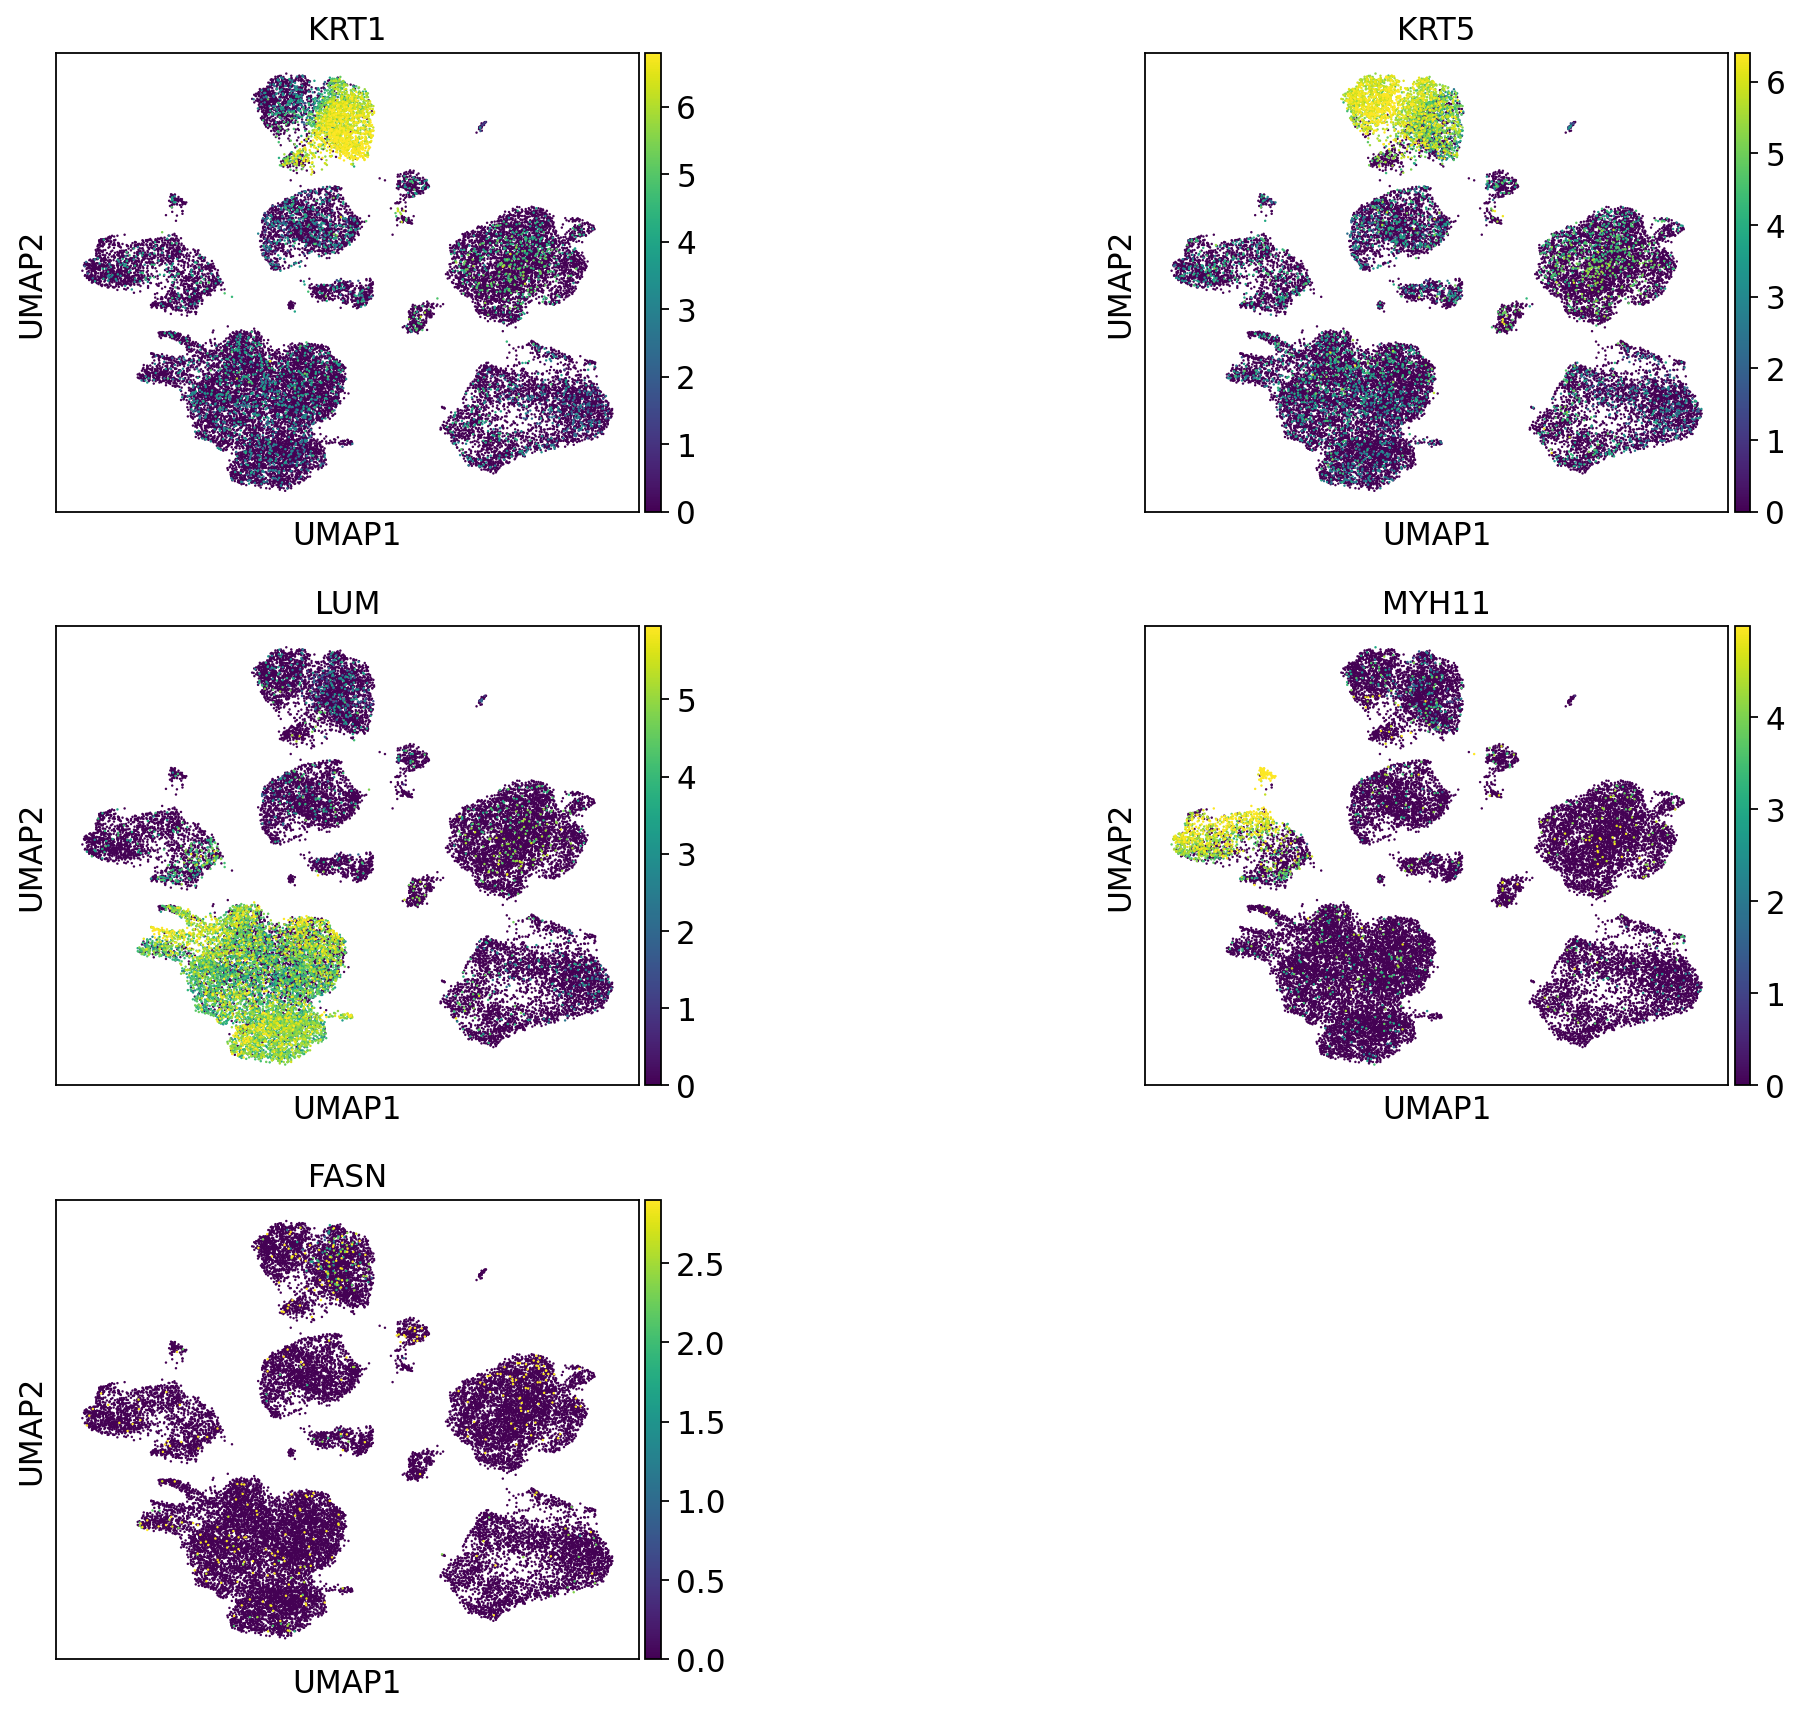

In [ ]:
sc.pl.umap(
    adata_query_final,
    color=["KRT1", "KRT5", "LUM", "MYH11", "FASN"],
    vmax="p99",
    wspace=0.7,
    ncols=2,
)

Store the final adata_query if wanted:

In [ ]:
# adata_query_final.write_h5ad("./query_with_refbased_emb_and_anns.h5ad")



---
**original License:**  
BSD 3-Clause License

Copyright (c) 2022, Mohammad Lotfollahi, Theislab
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.